## Digital Epidemiology 2018- 1st Assignment
### Nagham Almagout (1831467), Hassan Ismail (1735885)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import csv as cv
import os
import matplotlib.pyplot as plt
import re
import csv
import time
import pandas as pd
from pandas import Series
from random import randint
from scipy.signal import correlate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict
import warnings
warnings.filterwarnings('ignore')

In [5]:
Ground_Truth_Path="./Influent/Inf"
Wiki_Data_Path="./DEDATA/HWDE/Wiki/"

### Functions

In [6]:
"""This function is to normalize data and we used it for plotting propose"""
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df)
    df_normalized = pd.DataFrame(np_scaled)
    return df_normalized
"""This function is to read the ground truth data from csv files that we got by extracting the pdfs'
tables"""
def data_ground_truth_concat(path):
    df_list = []
    for year in list_years:
        g_data = pd.read_csv(path+str(year)+'.csv',usecols=['Settimana','Incidenza'])
        g_data = g_data.dropna()
        df_list.append(g_data)      
    result = pd.concat(df_list, axis = 0).reset_index(drop=True)
    return result
"""This function is to read the wiki page views data from csv files that we downloaded from wikipedia
tool"""
def data_wiki_pageviews_aggregator(paths):
    result=pd.DataFrame()
    for path in paths:
        g_data = pd.read_csv(path)
        g_data = g_data.dropna()
        result=pd.concat([result,g_data],axis=1)
        result= result.loc[:,~result.columns.duplicated()]
    return result
"""This function is to scale data by week"""
def week_scale(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data=data.resample('7D', on='Date').sum()
    return data
"""This function is to remove weeks from wiki page views data that are not in the ground truth data"""
def get_official_week(data,weeks_numbers):
    d=pd.DataFrame(pd.Series([i for i in range(1,len(data)+1)]))
    data['weeknum'] = d.iloc[:,0].values
    data=data.loc[data.weeknum.isin(weeks_numbers)]
    return data
"""This function is to compute the correlation between Influenza page views data and all 
other pages views data"""
def get_correlated_with_Influenza(data,pages_names):
    corr=dict()
    for name in pages_names[1:len(pages_names)]:
        corr[name]=np.corrcoef(data[name],data['Influenza'])[0,1]
    return corr
"""This function is to get the correlation between wiki pages views data and ground truth data"""
def get_correlated_with_GD(data,pages_names,gdf):
    corr=dict()
    for name in pages_names:
        corr[name]=np.corrcoef(data[name],gdf['Incidenza'])[0,1]
    return corr
def get_ALL_correlated_with_GD(data,pages_names,gdf):
    corr=dict()
    for name in pages_names:
        corr[name]=np.corrcoef(data[name],gdf['Incidenza'])[0,1]
    return corr

### PART 1
### Point 1.1
#### Process the Wikipedia pageview data for the "Influenza" page of the ItalianWikipedia (https://it.wikipedia.org/wiki/Influenza), aggregate the pageviews on a weekly time scale, and plot the resulting time series of page views for the current year and - ideally - also for previous years.

#### We chose these wiki pages to do our analysis :Influenza, Febbre, Rinorrea, Mialgia, Cefalea, Vomito, Vaccino influenza stagionale, Vaccino antinfluenzale, Amantadina, Antivirale, Artralgia, Influenza aviaria, Influenzavirus A, Influenzavirus A sottotipo H1N1, Virus dell'influenza A sottotipo H1N1, Zanamivir, Influenza spagnola, Influenza e fortuna del pensiero di Nietzsche.
To preparing our data, first we downloaded the wiki pages views data from wikipedia tool for all wiki pages that we chose and for dates from 01/July/2015 to 07/December/2018.
Then, we read the csv files that we download and merge all data together, so till now we have a data that contain the date and all page views count of previous wiki pages, then we scaled this data by week, and removed the weeks that are not in the ground truth data, so we got a data from week 42-2015 to week 17-2018.
For grond truth data we exctract the information from pdfs' tables using tabula software, for weeks from 42-2015 to week 17-2018.
Then we store these data in files all_data.csv, all_gdf.csv.

In [7]:
pages_names=['Influenza','Febbre','Rinorrea','Mialgia','Cefalea','Vomito','Vaccino influenza stagionale',
             'Vaccino antinfluenzale','Amantadina','Antivirale','Artralgia','Influenza aviaria','Influenzavirus A',
             'Influenzavirus A sottotipo H1N1','Virus dell\'influenza A sottotipo H1N1',
             'Zanamivir','Influenza spagnola','Influenza e fortuna del pensiero di Nietzsche']
paths=['2018I10.csv','2018A10.csv','2017I10.csv','2017A10.csv','2016I10.csv','2016A10.csv','2015I10.csv','2015A10.csv']
weeks_numbers=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,42,43,44,45,46,47,48,49,50,51,52,53]
data2018=data_wiki_pageviews_aggregator(paths[0:2])
data2017=data_wiki_pageviews_aggregator(paths[2:4])
data2016=data_wiki_pageviews_aggregator(paths[4:6])
data2015=data_wiki_pageviews_aggregator(paths[6:8])
data2018=week_scale(data2018.dropna())
data2017=week_scale(data2017.dropna())
data2016=week_scale(data2016.dropna())
data2015=week_scale(data2015.dropna())
data2018=get_official_week(data2018,weeks_numbers)
data2017=get_official_week(data2017,weeks_numbers)
data2016=get_official_week(data2016,weeks_numbers)
data2015=data2015[15:]
data2015['weeknum']=['2015-'+str(i) for i in range(42,54)]
data2018=data2018[0:17]
data2018.weeknum=['2018-'+str(data2018.weeknum[i]) for i in range(len(data2018))]
data2016.weeknum=['2016-'+str(data2016.weeknum[i]) for i in range(len(data2016))]
data2017.weeknum=['2017-'+str(data2017.weeknum[i]) for i in range(len(data2017))]
list_years = ["2015-2016","2016-2017","2017-2018"]
all_gdf=data_ground_truth_concat(Ground_Truth_Path)
gdf2015=all_gdf[0:12]
gdf2016=all_gdf[12:39]
gdf2017=all_gdf[39:67]
gdf2018=all_gdf[67:]
data2016=data2016[0:len(data2016)-2]
data2017=data2017[0:len(data2017)-1]
all_data=pd.concat([data2015,data2016,data2017,data2018])
all_data.to_csv("all_data.csv")
all_gdf.to_csv("all_gdf.csv")

In [7]:
all_data.index=all_data['weeknum']
all_data.head(3)

,Influenza,Febbre,Rinorrea,Mialgia,Cefalea,Vomito,Vaccino influenza stagionale,Vaccino antinfluenzale,Amantadina,Antivirale,Artralgia,Influenza aviaria,Influenzavirus A,Influenzavirus A sottotipo H1N1,Virus dell'influenza A sottotipo H1N1,Zanamivir,Influenza spagnola,Influenza e fortuna del pensiero di Nietzsche,weeknum
weeknum,,,,,,,,,,,,,,,,,,,
2015-42,1353.0,3253.0,487.0,1077.0,2330.0,1680.0,9.0,623.0,277.0,305.0,604,377,135,306,109,58,1478,103,2015-42
2015-43,1255.0,3313.0,404.0,930.0,2277.0,1590.0,1.0,617.0,282.0,300.0,471,445,119,296,47,58,1511,95,2015-43
2015-44,1194.0,3119.0,420.0,1004.0,2218.0,1796.0,8.0,755.0,293.0,309.0,586,722,130,340,41,52,1671,87,2015-44


In [8]:
all_gdf.head(3)

,Settimana,Incidenza
0,2015-42,0.40
1,2015-43,0.50
2,2015-44,0.68


#### Plotting the time series of Influenza wiki page for all years.

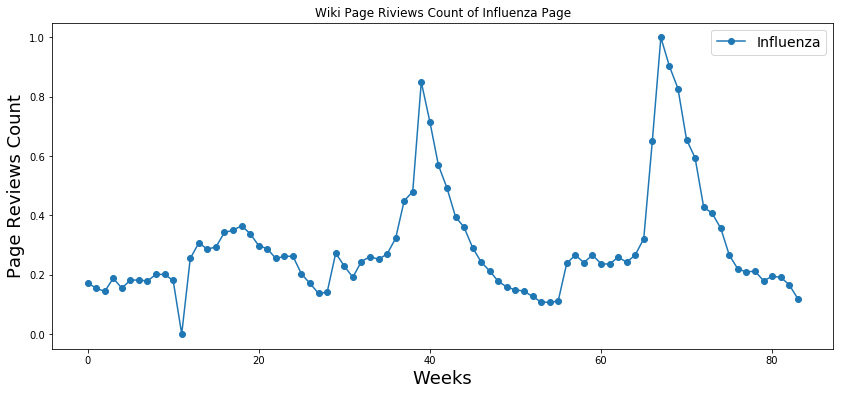

In [192]:
Influenza_dataInfluenza_data=pd.read_csv('all_data.csv',usecols=['Influenza'])
Influenza_data_norm=normalize_data(Influenza_data)
Influenza_data_norm.columns=['Influenza']
plt.figure(figsize=(14,6))
plt.plot([( row['Influenza']
          ) for index, row in Influenza_data_norm.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Page Reviews Count', fontsize=18)
plt.title('Wiki Page Riviews Count of Influenza Page')
plt.legend(['Influenza'], fontsize=14, loc='upperleft')
plt.show()

### 1.2 - Compare the time series from the official Influnet surveillance system with the time series of pageviews obtained in 1.1. 

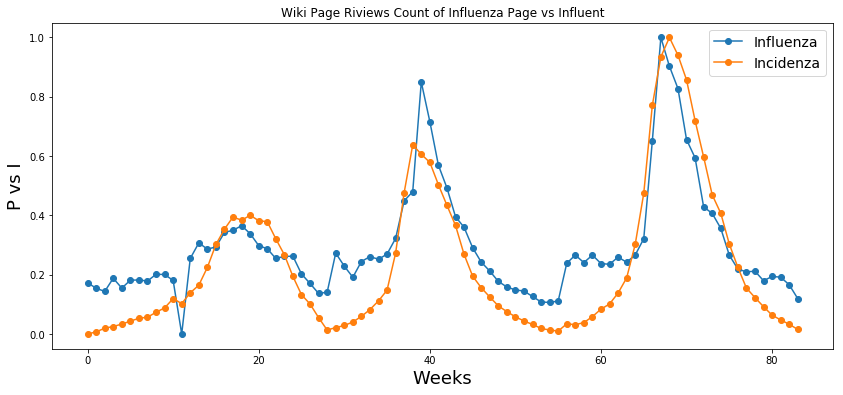

In [81]:
all_data=pd.read_csv('all_data.csv',usecols=['Date'])
Influenza_data=pd.read_csv('all_data.csv',usecols=['Influenza'])
Influenza_data_norm=normalize_data(Influenza_data)
Influenza_data_norm.columns=['Influenza']
all_gdf_data=pd.read_csv('all_gdf.csv',usecols=['Incidenza'])
all_gdf_data_norm=normalize_data(all_gdf_data)
all_gdf_data_norm.columns=['Incidenza']
all_data1=pd.concat([Influenza_data_norm,all_gdf_data_norm],axis=1)
plt.figure(figsize=(14,6))
plt.plot([( row['Influenza'],row['Incidenza']
          ) for index, row in all_data1.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('P vs I', fontsize=18)
plt.title('Wiki Page Riviews Count of Influenza Page vs Influent')
plt.legend(['Influenza','Incidenza'], fontsize=14, loc='upperleft')
plt.show()

We notice that, in general, two points:
+ This year's flu season is now more intense than last years.
+ It seems to be, these two time series have same behavior.

### Compute some measure of correlation between the two time series. Discuss your findings.
We used Pearson correlation coefficient

In [47]:
all_data_=pd.concat([Influenza_data,all_gdf_data],axis=1)
corr=np.corrcoef(all_data_['Influenza'],all_data_['Incidenza'])[0,1]
corr

0.9196015728372317

Pearson coefficient confirmed the result that we notice above.

#### ----------------------------------------------------------------------------------------------------------------------------------------------------

## Part 2
### Point 2.1
### plottind all wiki pages together with the Influnet signal as in 1.1.

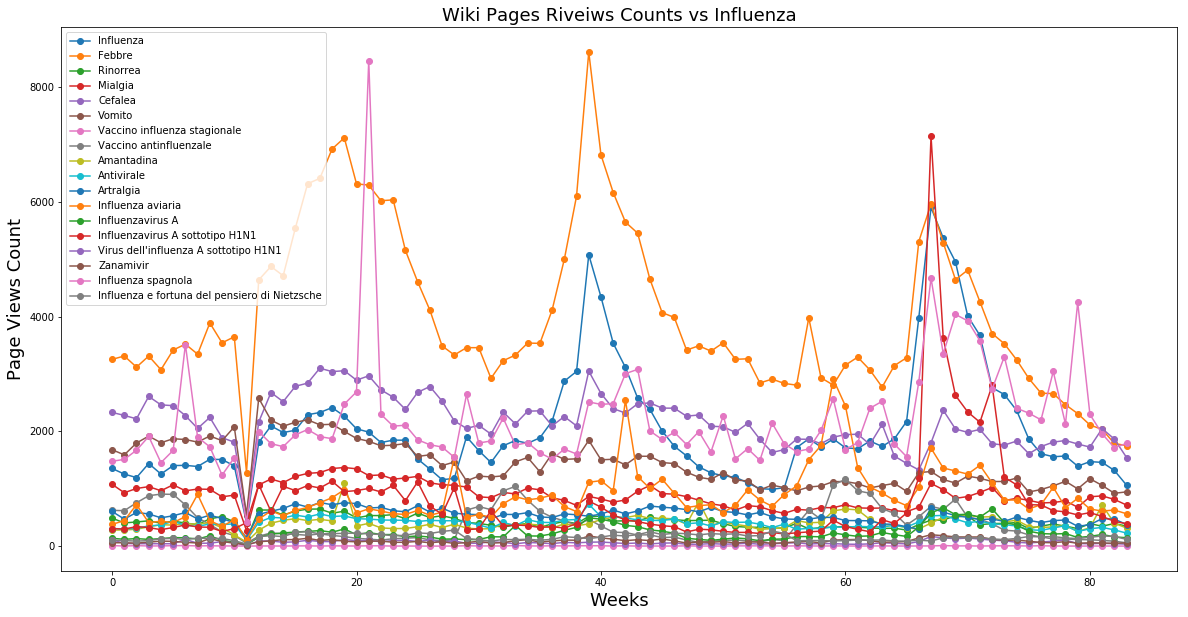

In [9]:
all_data=pd.read_csv('all_data.csv')
all_data_norm=normalize_data(all_data[pages_names])
all_data_norm.columns=pages_names
plt.figure(figsize=(20,10))
plt.plot([( row['Influenza'], row['Febbre'], row['Rinorrea'],row['Mialgia'],row['Cefalea'],
            row['Vomito'], row['Vaccino influenza stagionale'], row['Vaccino antinfluenzale'],row['Amantadina'],row['Antivirale'],
            row['Artralgia'], row['Influenza aviaria'], row['Influenzavirus A'],row['Influenzavirus A sottotipo H1N1'],row['Virus dell\'influenza A sottotipo H1N1'],
            row['Zanamivir'], row['Influenza spagnola'], row['Influenza e fortuna del pensiero di Nietzsche']
          ) for index, row in all_data.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Page Views Count', fontsize=18)
plt.title('Wiki Pages Riveiws Counts vs Influenza', fontsize=18)
plt.legend(pages_names, fontsize=10, loc='upperleft')
plt.show()

We notice that febbre page have the most views count.

We will try to plot the closest pages to Influenza page, to do that we will se the correlation between the Influenza page and other pages: 

In [196]:
corr=get_correlated_with_Influenza(all_data,pages_names)
corr=pd.DataFrame.from_dict(corr,orient='index')
corr=corr.sort_values(0, ascending=False)
corr.columns=['Influenza']
corr

,Influenza
Influenzavirus A,0.894922
Zanamivir,0.871012
Influenzavirus A sottotipo H1N1,0.711415
Febbre,0.641562
Antivirale,0.603038
Virus dell'influenza A sottotipo H1N1,0.579602
Influenza spagnola,0.464690
Influenza aviaria,0.403235
Rinorrea,0.291680
Amantadina,0.270903


So these pages are: Influenzavirus A, Zanamivir, Influenzavirus A sottotipo H1N1, Febbre.

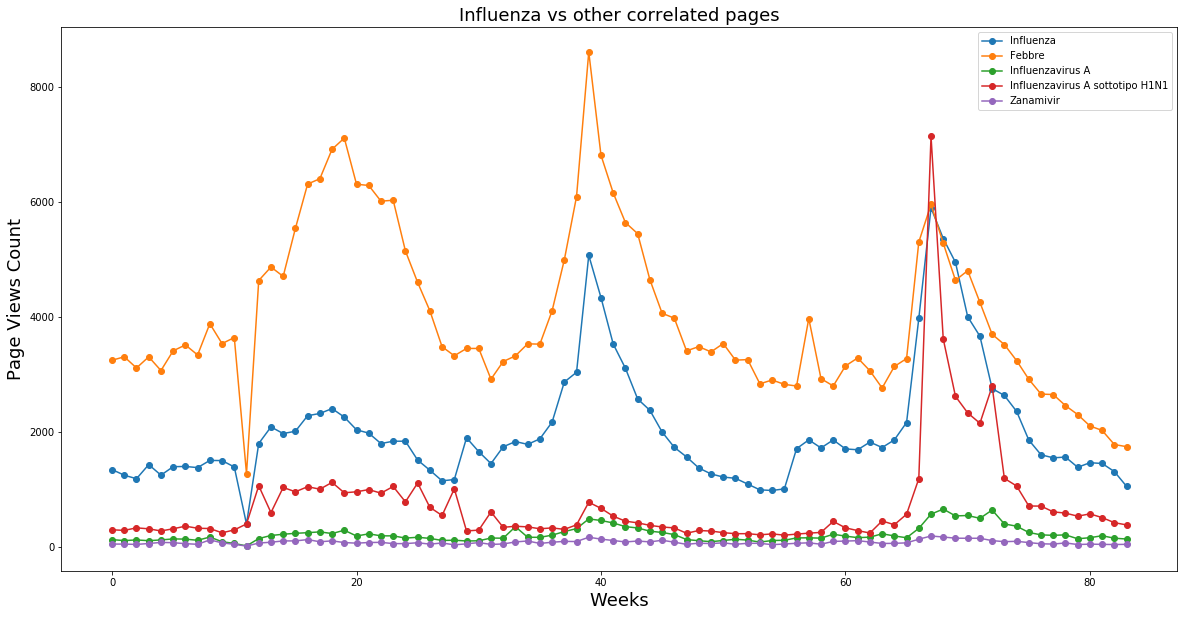

In [200]:
all_data=pd.read_csv('all_data.csv')
all_data_norm=normalize_data(all_data[pages_names])
all_data_norm.columns=pages_names
plt.figure(figsize=(20,10))
plt.plot([( row['Influenza'],row['Febbre'],
            row['Influenzavirus A'],row['Influenzavirus A sottotipo H1N1'],
            row['Zanamivir']
          ) for index, row in all_data.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Page Views Count', fontsize=18)
plt.title('Influenza vs other correlated pages', fontsize=18)
plt.legend(['Influenza','Febbre','Influenzavirus A', 'Influenzavirus A sottotipo H1N1', 'Zanamivir'], fontsize=10, loc='upperleft')
plt.show()

### 2.2 - For each of the selected Wikipedia pages, compute the same correlation with the Influnet time series that you computed in 1.2. Which of these correlations are strongest ? Did you discover a better page than "Influenza" in terms of correlation with the ground truth ?

In [71]:
corr=get_ALL_correlated_with_GD(all_data,pages_names,all_gdf)
corr=pd.DataFrame.from_dict(corr,orient='index')
corr=corr.sort_values(0, ascending=False)
corr.columns=['GD']
corr

,GD
Influenza,0.919602
Influenzavirus A,0.886823
Zanamivir,0.800572
Influenzavirus A sottotipo H1N1,0.716665
Febbre,0.625433
Virus dell'influenza A sottotipo H1N1,0.622894
Antivirale,0.526576
Influenza spagnola,0.493057
Influenza aviaria,0.280541
Rinorrea,0.277901


#### We notice that 'Influenza' page have the strongest correlation with Influent

##### We will plot some of most correlated pages with Ground Truth data and Influenza page

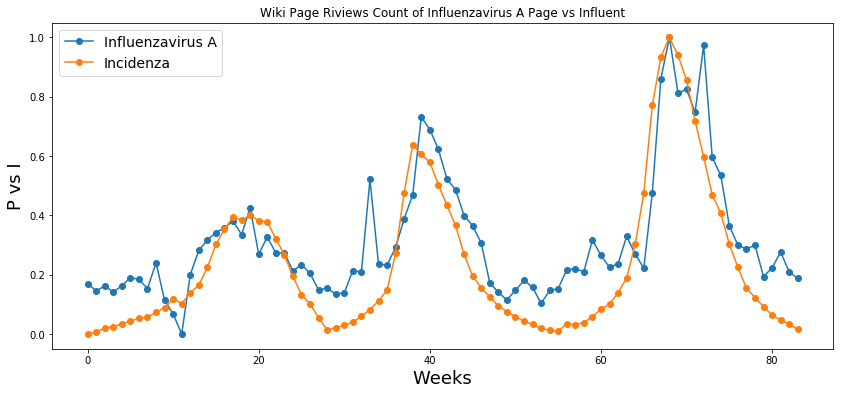

In [74]:
all_data=pd.read_csv('all_data.csv',usecols=['Date'])
Influenza_data=pd.read_csv('all_data.csv',usecols=['Influenzavirus A'])
Influenza_data_norm=normalize_data(Influenza_data)
Influenza_data_norm.columns=['Influenzavirus A']
all_gdf_data=pd.read_csv('all_gdf.csv',usecols=['Incidenza'])
all_gdf_data_norm=normalize_data(all_gdf_data)
all_gdf_data_norm.columns=['Incidenza']
all_data1=pd.concat([Influenza_data_norm,all_gdf_data_norm],axis=1)
plt.figure(figsize=(14,6))
plt.plot([( row['Influenzavirus A'],row['Incidenza']
          ) for index, row in all_data1.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('P vs I', fontsize=18)
plt.title('Wiki Page Riviews Count of Influenzavirus A Page vs Influent')
plt.legend(['Influenzavirus A','Incidenza'], fontsize=14, loc='upperleft')
plt.show()

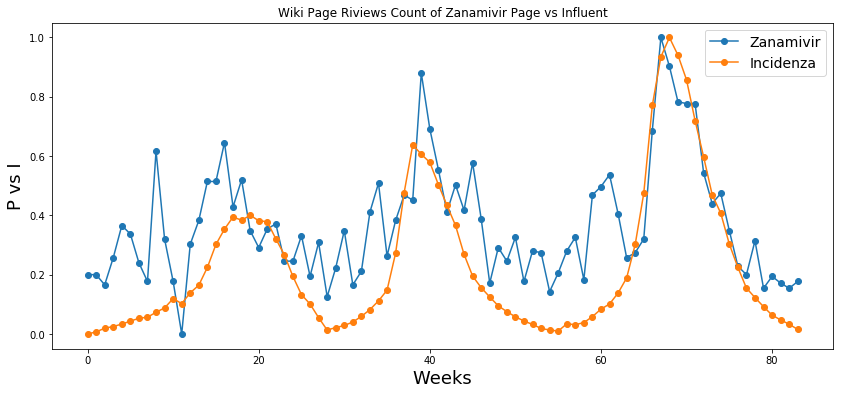

In [73]:
all_data=pd.read_csv('all_data.csv',usecols=['Date'])
Influenza_data=pd.read_csv('all_data.csv',usecols=['Zanamivir'])
Influenza_data_norm=normalize_data(Influenza_data)
Influenza_data_norm.columns=['Zanamivir']
all_gdf_data=pd.read_csv('all_gdf.csv',usecols=['Incidenza'])
all_gdf_data_norm=normalize_data(all_gdf_data)
all_gdf_data_norm.columns=['Incidenza']
all_data1=pd.concat([Influenza_data_norm,all_gdf_data_norm],axis=1)
plt.figure(figsize=(14,6))
plt.plot([( row['Zanamivir'],row['Incidenza']
          ) for index, row in all_data1.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('P vs I', fontsize=18)
plt.title('Wiki Page Riviews Count of Zanamivir Page vs Influent')
plt.legend(['Zanamivir','Incidenza'], fontsize=14, loc='upperleft')
plt.show()

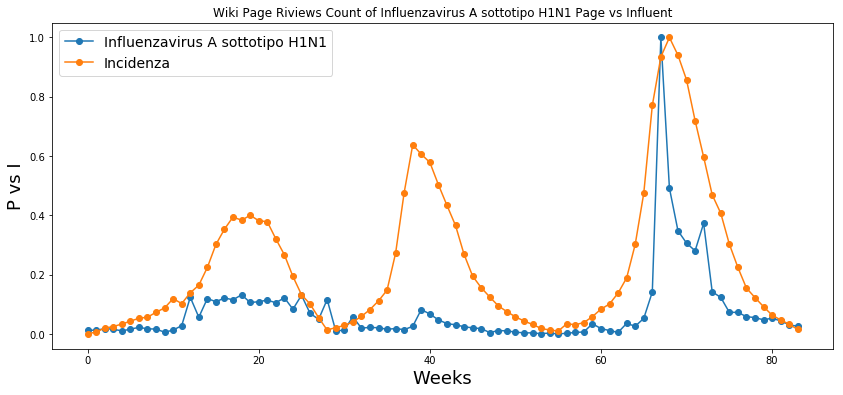

In [75]:
all_data=pd.read_csv('all_data.csv',usecols=['Date'])
Influenza_data=pd.read_csv('all_data.csv',usecols=['Influenzavirus A sottotipo H1N1'])
Influenza_data_norm=normalize_data(Influenza_data)
Influenza_data_norm.columns=['Influenzavirus A sottotipo H1N1']
all_gdf_data=pd.read_csv('all_gdf.csv',usecols=['Incidenza'])
all_gdf_data_norm=normalize_data(all_gdf_data)
all_gdf_data_norm.columns=['Incidenza']
all_data1=pd.concat([Influenza_data_norm,all_gdf_data_norm],axis=1)
plt.figure(figsize=(14,6))
plt.plot([( row['Influenzavirus A sottotipo H1N1'],row['Incidenza']
          ) for index, row in all_data1.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('P vs I', fontsize=18)
plt.title('Wiki Page Riviews Count of Influenzavirus A sottotipo H1N1 Page vs Influent')
plt.legend(['Influenzavirus A sottotipo H1N1','Incidenza'], fontsize=14, loc='upperleft')
plt.show()

By comparing the plots above and Influenza plot, we can be more ensure that the Influenza page views count have the strongest correlation with Influent.

#### -------------------------------------------------------------------------------------------------------------------------------------------------

### PART 3 (15 points)
3.1 - Build a regression model that predicts the Influnet incidence
	for a given week based on the Wikipedia pageview data for the same week.
	Your features are the Wikipedia pageview counts for the "Influenza" page,
	for all the pages you have selected in Part 2,
	and for any other page that you think might help (there are probably
	global trends that have nothing to do with influenza,
	and you might think of ways to control for them in your model.)
	Carry out any feature selection you think it's appropriate.
	Evaluate the performance of your model via cross-validation.


In [76]:
all_gdf=pd.read_csv('all_gdf.csv')
all_data=pd.read_csv('all_data.csv')
y=all_gdf['Incidenza'].values
X=all_data[pages_names].values
all_data=all_data.reset_index()

### Functions

In [140]:
"""predicts the Influnet incidence for a given week based on the Wikipedia pageview data
for the same week, using KFold cross validation method to get the best value"""
def pred_week(mod,X,y,week)
    kf = KFold(n_splits=10) # Define the split - into 10 folds 
    kf.get_n_splits(X)
    min_e=np.Inf
    pred=0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        mod.fit(X_train, y_train)
        idx = all_data.index[all_data['weeknum'] == week].tolist()[0]
        y_pred=mod.predict([X[idx]])[0]#[0]
        if abs([y[idx]][0]-y_pred)<min_e:
            min_e=abs([y[idx]][0]-y_pred)
            pred=y_pred
    print("Prediction of week " + str(week) +": " +str(pred))
    print("Real Value of week " + str(week) +": " +str([y[idx]][0]))
"""This function is to evaluate the performance of your model via cross-validation """
def pred_models(mod, X,y,week):
    r2=dict()
    mse=dict()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    for i in range(3,10):
        r = cross_val_score(estimator = mod, X = X_train, y = y_train, cv = i, scoring = "r2")
        r2[i]=r.mean()
    r2_score=pd.DataFrame.from_dict(r2,orient='index')
    mod.fit(X_train, y_train)
    accuracy=mod.score(X_test, y_test)
    preds=pd.DataFrame(mod.predict(X_test))
    preds=pd.concat([preds,pd.DataFrame(y_test)],axis=1)
    preds.columns=['Predictions', 'Real Values']
    print(pred_week(mod,X,y,week))
    return preds,r2_score


### Linear Regrission

In [244]:
from scipy import stats
from sklearn.model_selection import KFold
pLI,r2L=pred_models(linear_model.LinearRegression(), X,y,'2018-17')
r2L.columns=['Linear Regrission']
r2L=r2L.sort_values('Linear Regrission', ascending=False)
np.mean(r2L)

Prediction of week 2018-17: 0.9573578859016068
Real Value of week 2018-17: 0.62
None


Linear Regrission    0.446756
dtype: float64

In [245]:
np.corrcoef(list(pLI['Predictions']), list(pLI['Real Values']))[0, 1]

0.9561645075440572

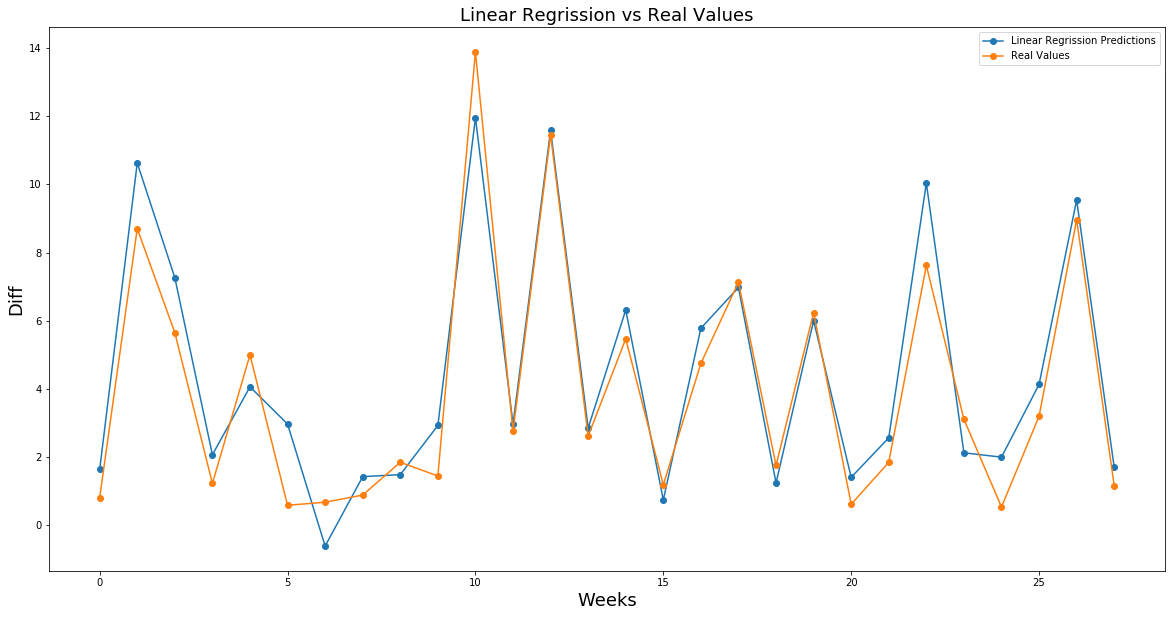

In [252]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pLI.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Linear Regrission vs Real Values', fontsize=18)
plt.legend(['Linear Regrission Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

### Ridge

In [236]:
pR,r2R=pred_models(linear_model.Ridge(alpha = 1.0), X,y,'2018-17')
r2R.columns=['Ridge']
r2R=r2R.sort_values('Ridge', ascending=False)
np.mean(r2R)

Prediction of week 2018-17: 0.9571796564702946
Real Value of week 2018-17: 0.62
None


Ridge    0.447198
dtype: float64

In [246]:
np.corrcoef(list(pR['Predictions']), list(pR['Real Values']))[0, 1]

0.9561774709943802

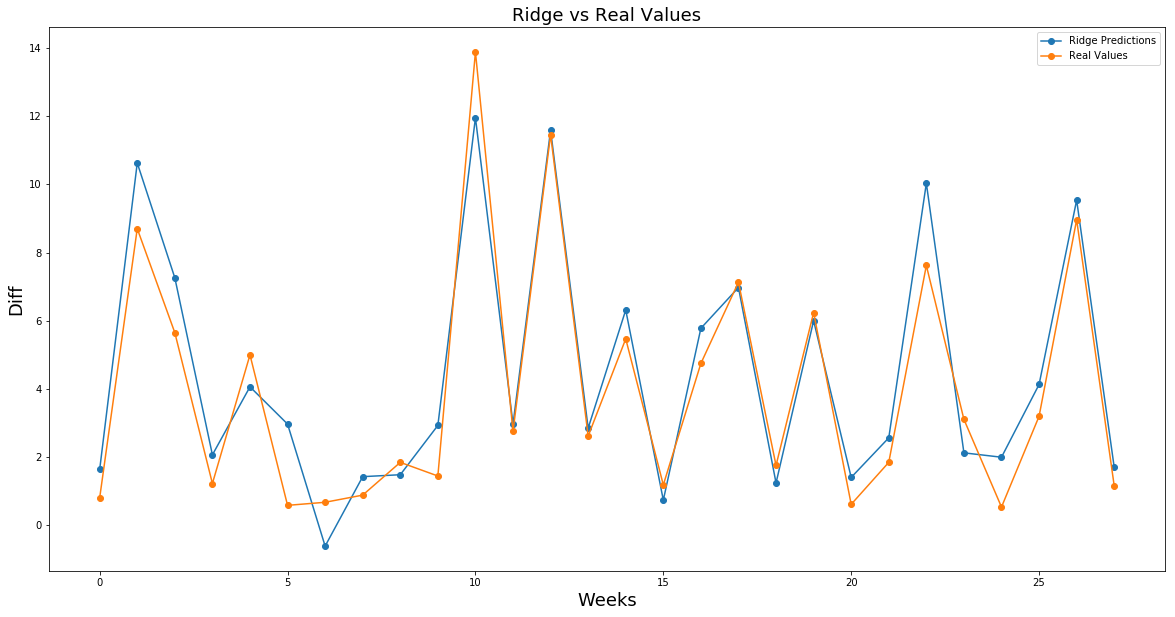

In [251]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pR.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Ridge vs Real Values', fontsize=18)
plt.legend(['Ridge Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

### BayesianRidge()

In [237]:
pB,r2B=pred_models(linear_model.BayesianRidge(), X,y,'2018-17')
r2B.columns=['Bayesian Ridge']
r2B=r2B.sort_values('Bayesian Ridge', ascending=False)
np.mean(r2B)

Prediction of week 2018-17: 0.8871883562549032
Real Value of week 2018-17: 0.62
None


Bayesian Ridge    0.662174
dtype: float64

In [247]:
np.corrcoef(list(pB['Predictions']), list(pB['Real Values']))[0, 1]

0.9640742895247948

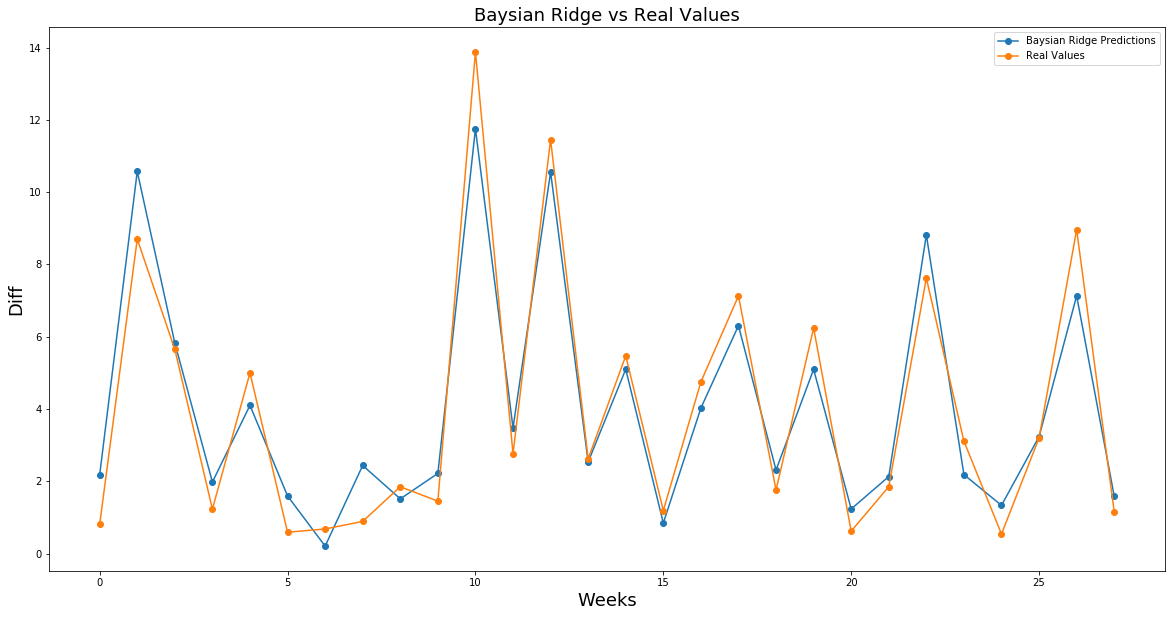

In [253]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pB.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Baysian Ridge vs Real Values', fontsize=18)
plt.legend(['Baysian Ridge Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

### KernelRidge

In [238]:
from sklearn.kernel_ridge import KernelRidge
pK,r2K=pred_models(KernelRidge(alpha=1.0), X,y,'2018-17')
r2K.columns=['KernelRidge']
r2K=r2K.sort_values('KernelRidge', ascending=False)
np.mean(r2K)

Prediction of week 2018-17: 0.9389152973890305
Real Value of week 2018-17: 0.62
None


KernelRidge    0.44989
dtype: float64

In [248]:
np.corrcoef(list(pK['Predictions']), list(pK['Real Values']))[0, 1]

0.9568890825789323

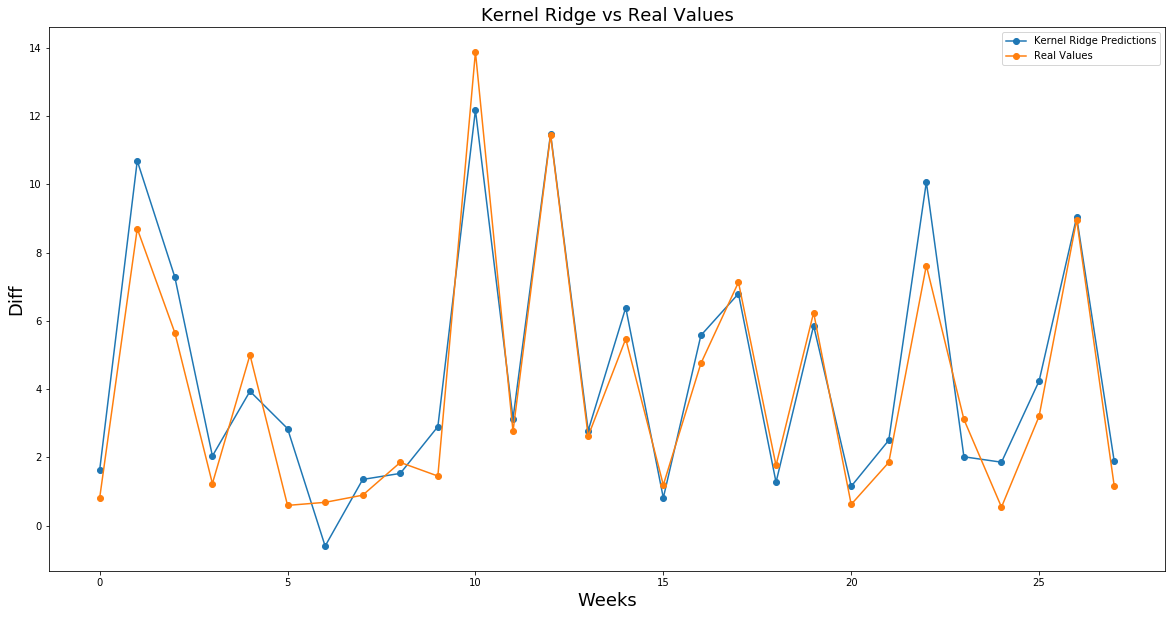

In [254]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pK.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Kernel Ridge vs Real Values', fontsize=18)
plt.legend(['Kernel Ridge Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

#### We notice that usinf KFold cross validation with nsplit=10, the best value of the predictions of the given week is 0.8871883562549032 , with model Baysian Ridge

In [218]:
all_models=pd.concat([pK['Predictions'],pB['Predictions'],pR['Predictions'],pLI['Predictions'],pLI['Real Values']],axis=1)

In [219]:
all_models.columns=['Kernel Ridge','Baysian Ridge','Ridge','Linear Regrission','Real Values']

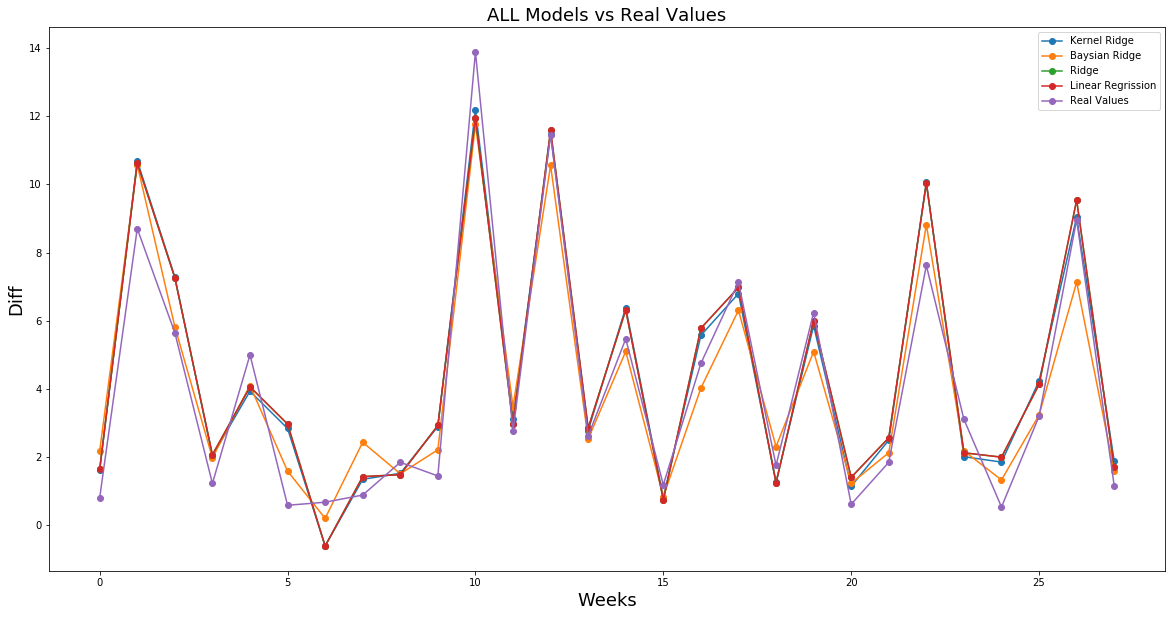

In [255]:
plt.figure(figsize=(20,10))
plt.plot([( row['Kernel Ridge'], row['Baysian Ridge'],
                row['Ridge'], row['Linear Regrission'],
                row['Real Values']
              ) for index, row in all_models.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('ALL Models vs Real Values', fontsize=18)
plt.legend(['Kernel Ridge','Baysian Ridge','Ridge','Linear Regrission','Real Values'], fontsize=10, loc='upperleft')
plt.show()

We notice that from the mean of r2_score, a pearson correlation coefficients value, and best value of prediction of a given week that the best fitted model is Baysian Ridge

#### Now, we will remove the pages that have a low correlation with the Influent to see if the results will be better, and these pages are:Influenza, Influenzavirus A, Zanamivir, Influenzavirus A sottotipo H1N1, Febbre, Virus dell'influenza A sottotipo H1N1, Antivirale 	

In [102]:
all_gdf=pd.read_csv('all_gdf.csv')
all_data=pd.read_csv('all_data.csv')
y=all_gdf['Incidenza'].values
X=all_data[['Influenza','Influenzavirus A','Zanamivir','Influenzavirus A sottotipo H1N1','Febbre','Virus dell\'influenza A sottotipo H1N1','Antivirale']].values
all_data=all_data.reset_index()

### Linear Regrission

In [104]:
from scipy import stats
from sklearn.model_selection import KFold
pLI,r2L=pred_models(linear_model.LinearRegression(), X,y,'2018-17')
r2L.columns=['Linear Regrission']
r2L=r2L.sort_values('Linear Regrission', ascending=False)
np.mean(r2L)

Prediction of week 2018-17: 0.6440352121778932
Real Value of week 2018-17: 0.62
None


Linear Regrission    0.553844
dtype: float64

In [105]:
np.corrcoef(list(pLI['Predictions']), list(pLI['Real Values']))[0, 1]

0.9596372113727891

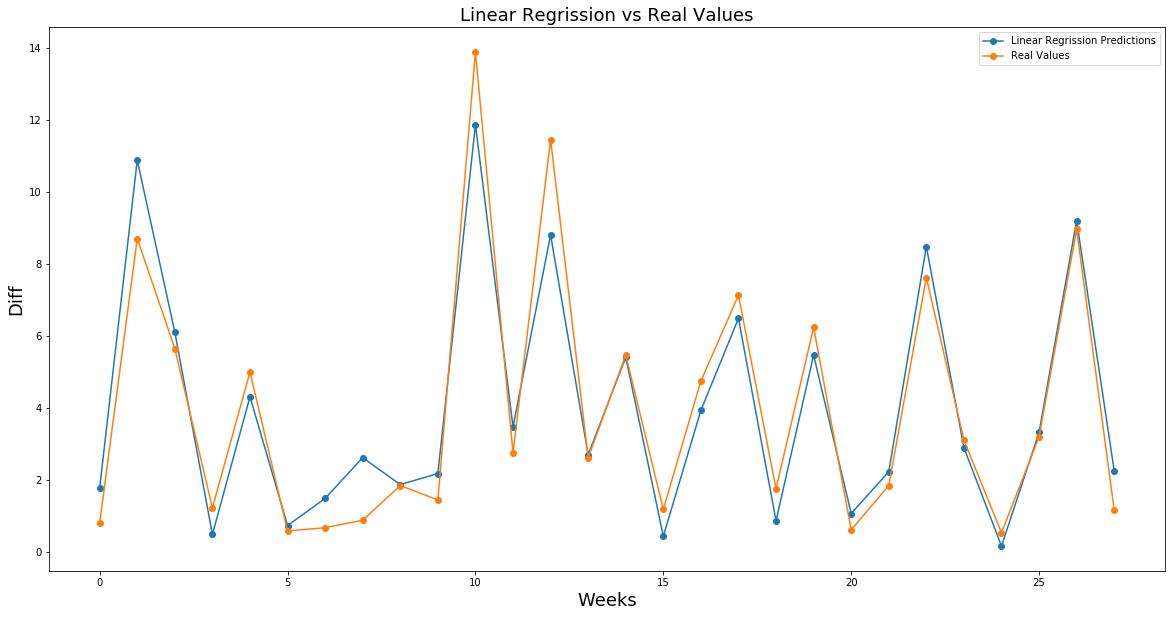

In [106]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pLI.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Linear Regrission vs Real Values', fontsize=18)
plt.legend(['Linear Regrission Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

### Ridge

In [107]:
pR,r2R=pred_models(linear_model.Ridge(alpha = 1.0), X,y,'2018-17')
r2R.columns=['Ridge']
r2R=r2R.sort_values('Ridge', ascending=False)
np.mean(r2R)

Prediction of week 2018-17: 0.6440331130014383
Real Value of week 2018-17: 0.62
None


Ridge    0.553854
dtype: float64

In [108]:
np.corrcoef(list(pR['Predictions']), list(pR['Real Values']))[0, 1]

0.9596373308921899

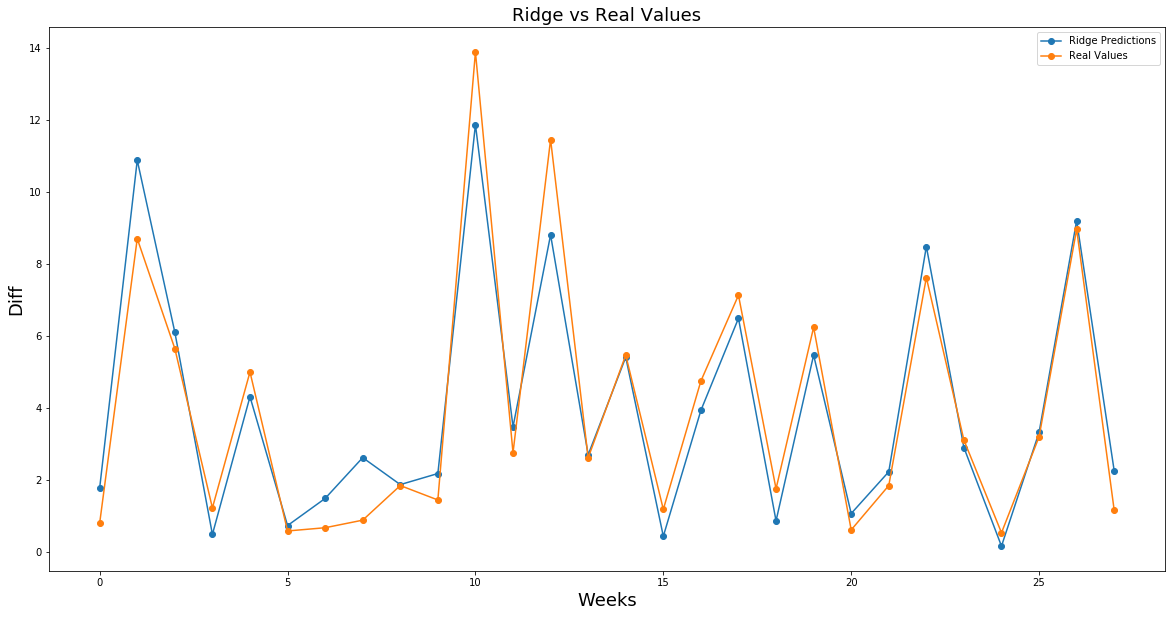

In [109]:

plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pR.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Ridge vs Real Values', fontsize=18)
plt.legend(['Ridge Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

### BayesianRidge()

In [110]:
pB,r2B=pred_models(linear_model.BayesianRidge(), X,y,'2018-17')
r2B.columns=['Bayesian Ridge']
r2B=r2B.sort_values('Bayesian Ridge', ascending=False)
np.mean(r2B)

Prediction of week 2018-17: 0.6795954973215497
Real Value of week 2018-17: 0.62
None


Bayesian Ridge    0.616487
dtype: float64

In [111]:
np.corrcoef(list(pB['Predictions']), list(pB['Real Values']))[0, 1]

0.9617647977457224

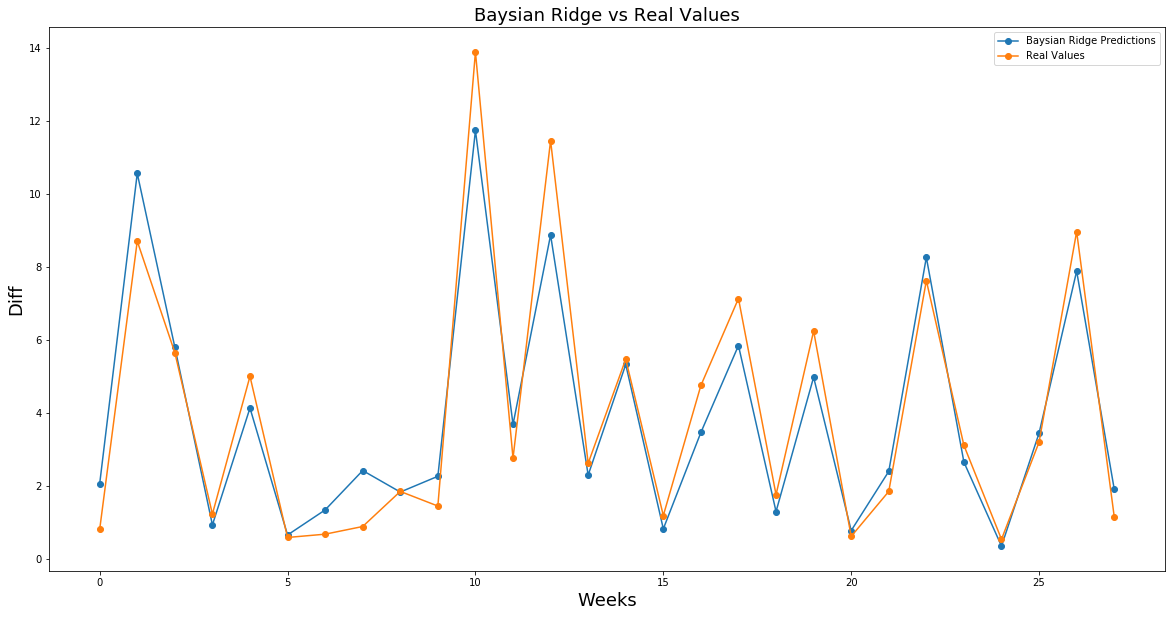

In [112]:

plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pB.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Baysian Ridge vs Real Values', fontsize=18)
plt.legend(['Baysian Ridge Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

### KernelRidge

In [113]:

from sklearn.kernel_ridge import KernelRidge
pK,r2K=pred_models(KernelRidge(alpha=1.0), X,y,'2018-17')
r2K.columns=['KernelRidge']
r2K=r2K.sort_values('KernelRidge', ascending=False)
np.mean(r2K)

Prediction of week 2018-17: 1.22686155885458
Real Value of week 2018-17: 0.62
None


KernelRidge    0.579787
dtype: float64

In [114]:
np.corrcoef(list(pK['Predictions']), list(pK['Real Values']))[0, 1]

0.9555053706083159

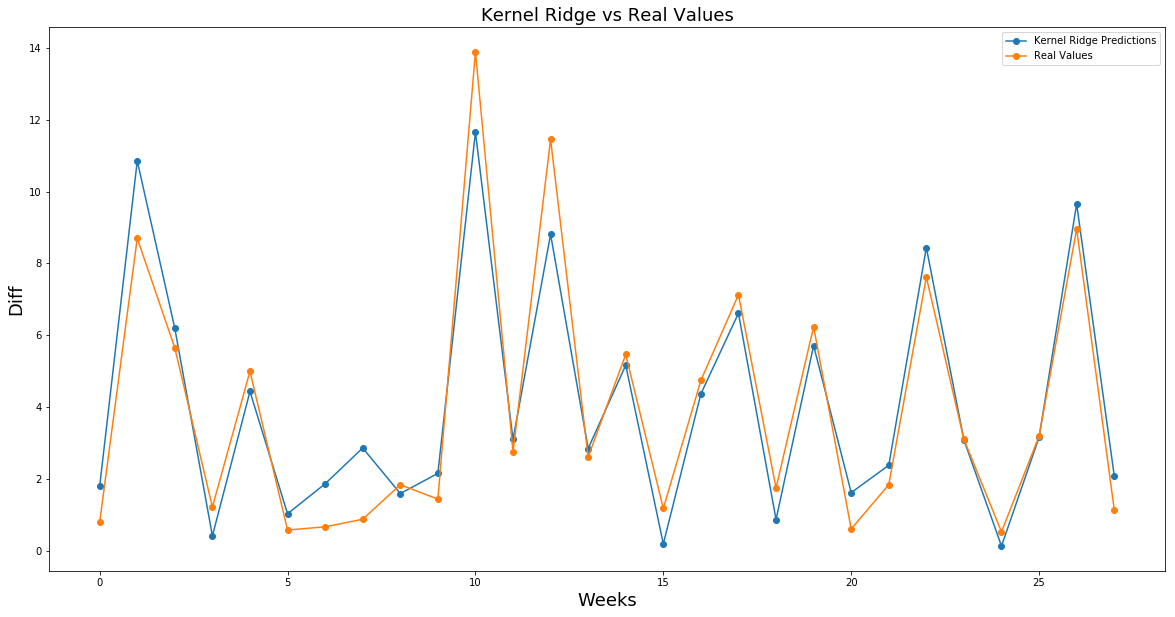

In [115]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pK.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Kernel Ridge vs Real Values', fontsize=18)
plt.legend(['Kernel Ridge Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

We notice that usinf KFold cross validation with nsplit=10, the best value of the predictions of the given week is 0.6440331130014383 , with model Ridge, and it is much better than before, while the real value is 0.62 and that meaning after removing pages with low collerelated values improve the analysis model.

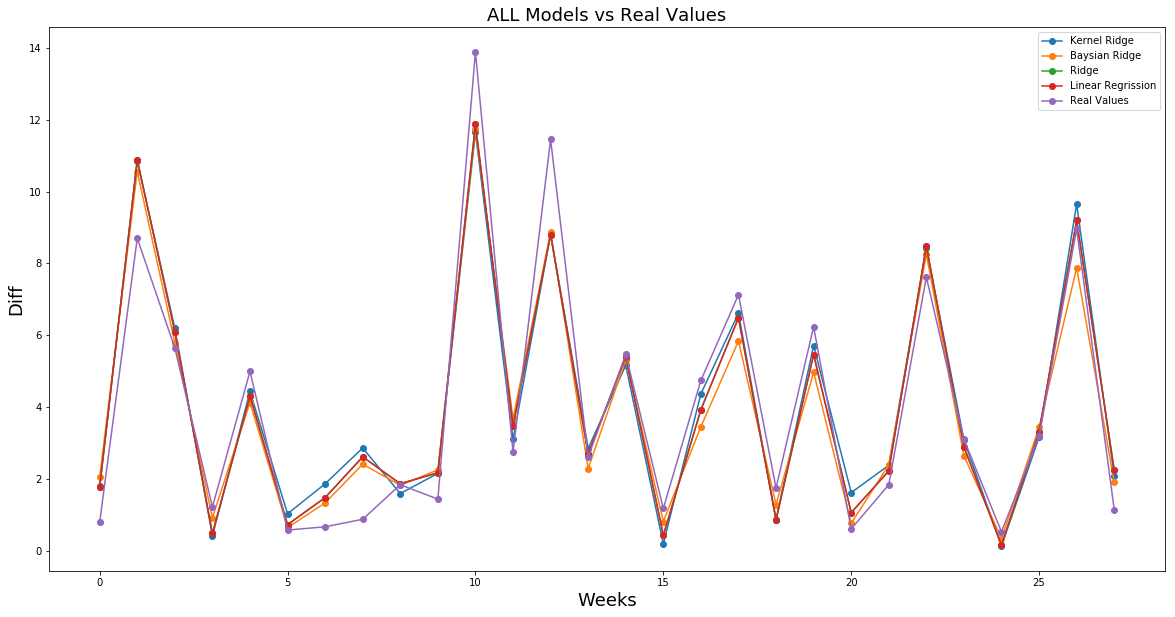

In [116]:
all_models=pd.concat([pK['Predictions'],pB['Predictions'],pR['Predictions'],pLI['Predictions'],pLI['Real Values']],axis=1)
all_models.columns=['Kernel Ridge','Baysian Ridge','Ridge','Linear Regrission','Real Values']

plt.figure(figsize=(20,10))
plt.plot([( row['Kernel Ridge'], row['Baysian Ridge'],
                row['Ridge'], row['Linear Regrission'],
                row['Real Values']
              ) for index, row in all_models.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('ALL Models vs Real Values', fontsize=18)
plt.legend(['Kernel Ridge','Baysian Ridge','Ridge','Linear Regrission','Real Values'], fontsize=10, loc='upperleft')
plt.show()

Baysian Ridge still the best fitted model with higher t2_score and pearson coefficient

### To improve our model we add these features:
+ The Influnet incidence for the week preceding the target week
+ The pageview counts of the pages you selected in point 3.1 for the week preceding the target week

In [167]:
all_gdf=pd.read_csv('all_gdf.csv')
all_data=pd.read_csv('all_data.csv')
all_data=all_data[['Influenza','Influenzavirus A','Zanamivir','Influenzavirus A sottotipo H1N1','Febbre','Virus dell\'influenza A sottotipo H1N1','Antivirale','weeknum']]
all_data=all_data.reset_index()
pages_names=['Influenza','Influenzavirus A','Zanamivir','Influenzavirus A sottotipo H1N1','Febbre','Virus dell\'influenza A sottotipo H1N1','Antivirale']
pages_names_prev = []
for p in pages_names:
    pages_names_prev.append('prev_'+p)
all_data_prev = all_data.copy()
newIndex = list(all_data_prev.index)
newIndex.pop()
all_data_prev = all_data_prev.drop(['weeknum'], axis=1)
all_data_prev.drop(all_data_prev.head(1).index, inplace= True)
all_data_prev = all_data_prev.rename(index=dict(zip(list(all_data_prev.index.values),newIndex)))
newColumns = list(all_data_prev.columns.values)
colDict = dict()
for i in range(len(pages_names)):
    colDict[pages_names[i]] = pages_names_prev[i]
all_data_prev.rename(columns =colDict, inplace = True )
all_data.drop(all_data.tail(1).index,inplace=True)
new_data = pd.concat([all_data, all_data_prev], axis=1)
X = new_data[pages_names+pages_names_prev].values
all_gdf.drop(all_gdf.tail(1).index,inplace=True)
y = all_gdf['Incidenza'].values

## Linear Regrission

In [168]:
from scipy import stats
from sklearn.model_selection import KFold
pLI,r2L=pred_models(linear_model.LinearRegression(), X,y,'2018-16')
r2L.columns=['Linear Regrission']
r2L=r2L.sort_values('Linear Regrission', ascending=False)
np.mean(r2L)

Prediction of week 2018-16: 0.9802322759756366
Real Value of week 2018-16: 0.87
None


Linear Regrission    0.248747
dtype: float64

In [169]:
np.corrcoef(list(pLI['Predictions']), list(pLI['Real Values']))[0, 1]

0.9760913309120592

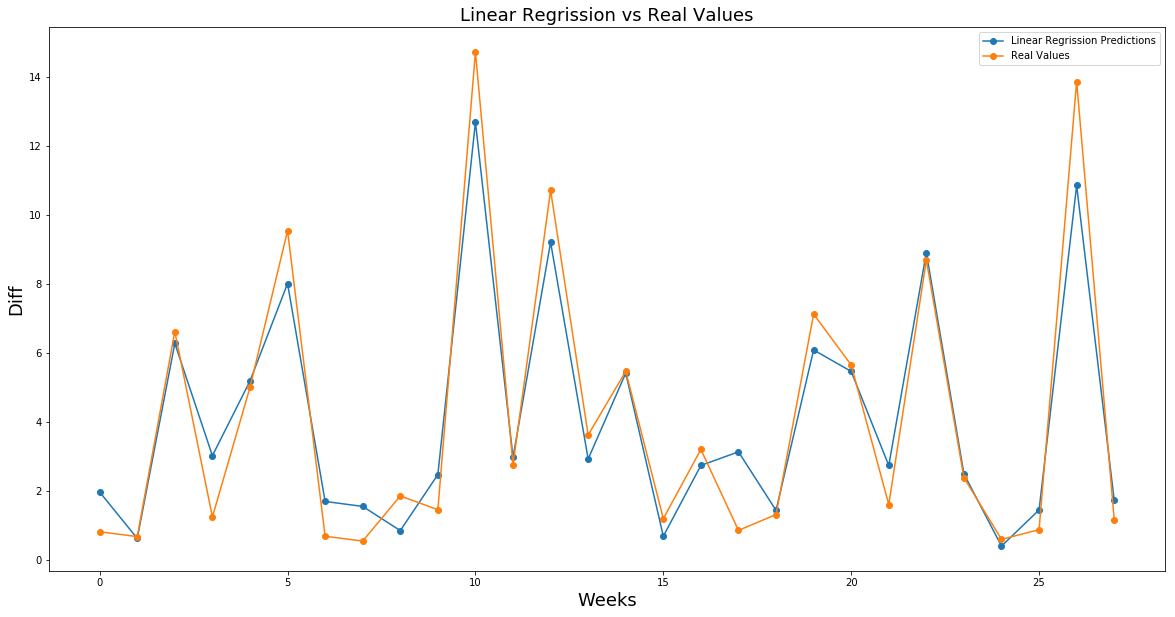

In [170]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pLI.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Linear Regrission vs Real Values', fontsize=18)
plt.legend(['Linear Regrission Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

### Ridge

In [171]:
pR,r2R=pred_models(linear_model.Ridge(alpha = 1.0), X,y,'2018-16')
r2R.columns=['Ridge']
r2R=r2R.sort_values('Ridge', ascending=False)
np.mean(r2R)

Prediction of week 2018-16: 0.9802295842287654
Real Value of week 2018-16: 0.87
None


Ridge    0.248786
dtype: float64

In [172]:
np.corrcoef(list(pR['Predictions']), list(pR['Real Values']))[0, 1]

0.9760918649271927

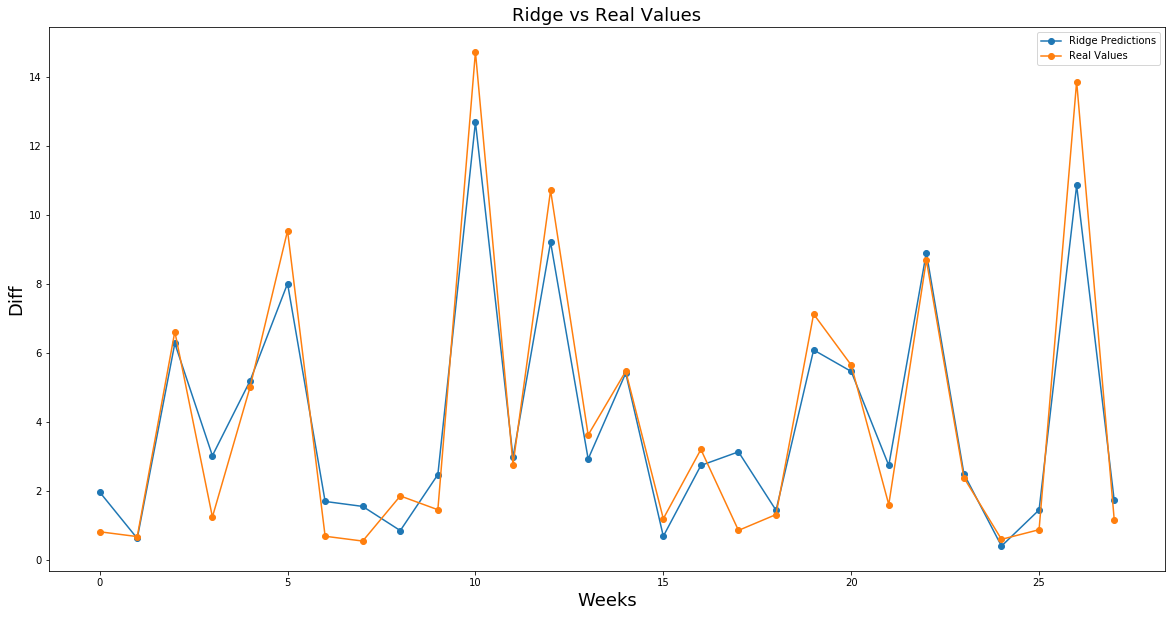

In [173]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pR.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Ridge vs Real Values', fontsize=18)
plt.legend(['Ridge Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

### BayesianRidge()

In [174]:
pB,r2B=pred_models(linear_model.BayesianRidge(), X,y,'2018-16')
r2B.columns=['Bayesian Ridge']
r2B=r2B.sort_values('Bayesian Ridge', ascending=False)
np.mean(r2B)

Prediction of week 2018-16: 0.9302634975040158
Real Value of week 2018-16: 0.87
None


Bayesian Ridge    0.369614
dtype: float64

In [175]:
np.corrcoef(list(pB['Predictions']), list(pB['Real Values']))[0, 1]

0.9831977354145829

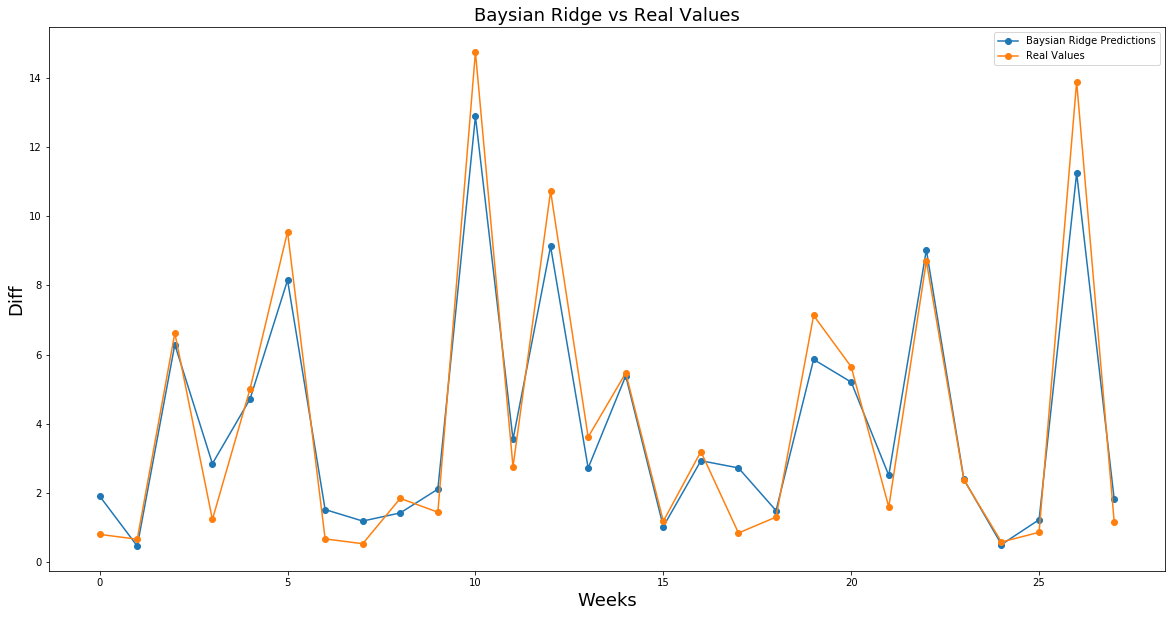

In [176]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pB.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Baysian Ridge vs Real Values', fontsize=18)
plt.legend(['Baysian Ridge Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

### KernelRidge

In [177]:
from sklearn.kernel_ridge import KernelRidge
pK,r2K=pred_models(KernelRidge(alpha=1.0), X,y,'2018-16')
r2K.columns=['KernelRidge']
r2K=r2K.sort_values('KernelRidge', ascending=False)
np.mean(r2K)

Prediction of week 2018-16: 1.3804214429110289
Real Value of week 2018-16: 0.87
None


KernelRidge    0.306319
dtype: float64

In [178]:
np.corrcoef(list(pK['Predictions']), list(pK['Real Values']))[0, 1]

0.975332691077521

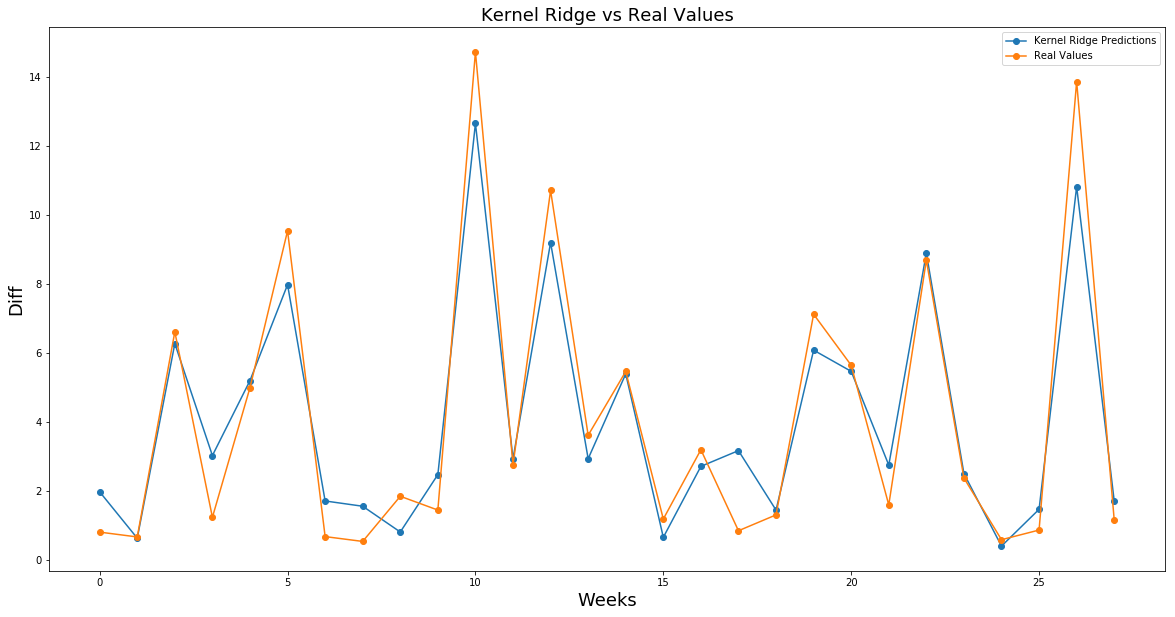

In [179]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['Real Values']
              ) for index, row in pK.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Kernel Ridge vs Real Values', fontsize=18)
plt.legend(['Kernel Ridge Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

We notice that usinf KFold cross validation with nsplit=10, the best value of the predictions of the given week is 0.9302634975040158 with Baysian Ridge model, and the real value is 0.87

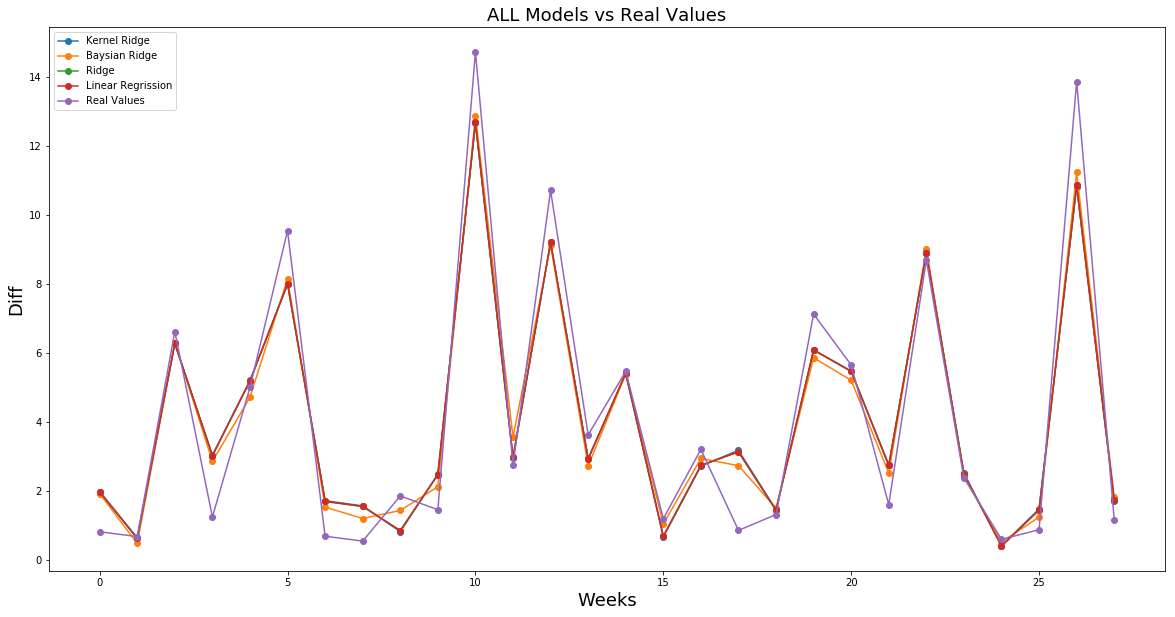

In [180]:
all_models=pd.concat([pK['Predictions'],pB['Predictions'],pR['Predictions'],pLI['Predictions'],pLI['Real Values']],axis=1)
all_models.columns=['Kernel Ridge','Baysian Ridge','Ridge','Linear Regrission','Real Values']

plt.figure(figsize=(20,10))
plt.plot([( row['Kernel Ridge'], row['Baysian Ridge'],
                row['Ridge'], row['Linear Regrission'],
                row['Real Values']
              ) for index, row in all_models.iterrows()], 'o-')
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('ALL Models vs Real Values', fontsize=18)
plt.legend(['Kernel Ridge','Baysian Ridge','Ridge','Linear Regrission','Real Values'], fontsize=10, loc='upperleft')
plt.show()

In this point:Our best model is Baysian Ridge with Pearson coefficient: 0.9831977354145829 and r2_score:0.369614

### Reference
+ [1] D.J. McIver & J. S. Brownstein (2014), "Wikipedia Usage Estimates Prevalence of Influenza-Like Illness in the United States in Near Real-Time", PLoS Comput Biol 10(4): e1003581
http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003581
(also in the course Dropbox folder: Literature/mciver2014_fluwikipedia.pdf )
+ [2] Wikipedia tool: https://bit.ly/2SjFSsd